In [2]:
from google.colab import drive
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, Conv1D, Dropout, LSTM
from sklearn.model_selection import train_test_split

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/AI/dataset/Energy_Power_Weather.csv")
df

,kilowatt-hours,Date,TempMin,TempMax,Weather,Wind_speed,Humidity,ALLSKY_SFC_SW_DWN
0,2.165,2019-01-28,18.69,24.43,Patchy rain possible,2.81,88.88,1.99
1,6.470,2019-01-29,19.56,24.33,Patchy rain possible,3.48,88.50,2.83
2,9.157,2019-01-30,19.38,24.42,Patchy rain possible,3.29,87.06,5.41
3,16.269,2019-01-31,19.06,25.05,Sunny,1.98,82.44,5.83
4,8.447,2019-02-01,19.03,24.25,Moderate rain at times,2.64,83.88,5.06
...,...,...,...,...,...,...,...,...
1757,4.514,2023-11-20,21.48,25.49,Light rain shower,3.85,85.00,4.07
1758,11.096,2023-11-21,21.13,25.69,Patchy rain possible,2.61,82.06,4.53
1759,4.860,2023-11-22,22.58,27.11,Light rain shower,2.69,84.19,2.83
1760,13.984,2023-11-23,22.44,26.48,Light rain shower,3.73,85.31,4.98


In [101]:
from scipy.stats import spearmanr

# Giả sử X và Y là hai mảng numpy của bạn
X = df["Humidity"].values
Y = df["ALLSKY_SFC_SW_DWN"].values

# Tính hệ số tương quan Spearman
coef, p = spearmanr(X, Y)

print("Hệ số tương quan Spearman: ", coef)
print("Giá trị p: ", p)


Hệ số tương quan Spearman:  -0.6181123619454167
Giá trị p:  3.3008041439220077e-186


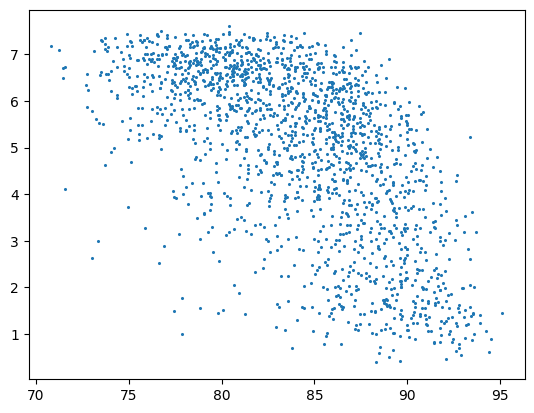

In [99]:
plt.scatter(df["Humidity"], df["ALLSKY_SFC_SW_DWN"], s=1.5)
plt.show()

# 0. Khai phá dữ liệu

In [4]:
weather = {'Patchy rain possible': 0.27,
           'Sunny': 0.99,
           'Moderate rain at times': 0.22,
           'Overcast': 0.5,
           'Partly cloudy': 0.67,
           'Cloudy': 0.56,
           'Heavy rain at times': 0.16,
           'Moderate or heavy rain shower': 0.11,
           'Light rain shower': 0.33,
           'Mist': 0.44,
           'Patchy light rain with thunder': 0.24,
           'Thundery outbreaks possible': 0.31,
           'Patchy light drizzle': 0.39,
           'Torrential rain shower': 0.01
}

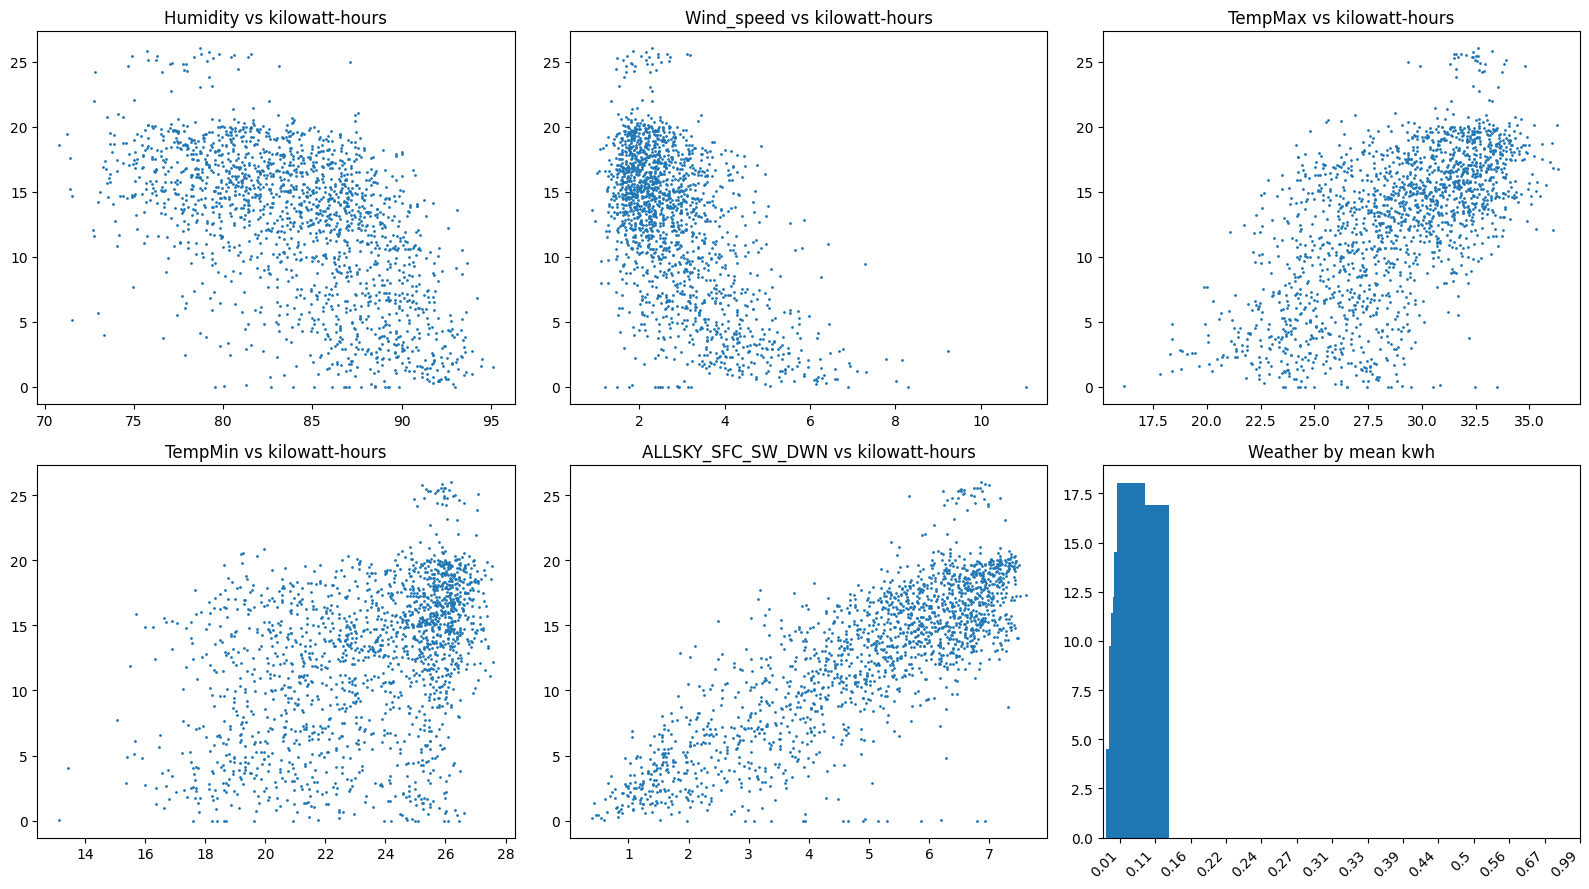

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

col = ["ALLSKY_SFC_SW_DWN", "TempMin", "TempMax", "Wind_speed", "Humidity"]
for ax in (ax1, ax2, ax3, ax4, ax5):
    c = col.pop()
    ax.scatter(df[c], df['kilowatt-hours'], s=1)
    ax.title.set_text(f"{c} vs kilowatt-hours")

df_weather = df.groupby("Weather").agg({"kilowatt-hours": "mean"}).reset_index()
df_weather["Values"] = df_weather["Weather"].map(weather)
df_weather = df_weather.sort_values("Values")

ax6.bar(df_weather["Weather"], df_weather['kilowatt-hours'])
ax6.set_xticks(ticks=range(0, len(df_weather["Weather"])), labels=df_weather["Weather"], rotation=45, ha="right")
ax6.title.set_text("Weather by mean kwh")

plt.tight_layout()
plt.show()

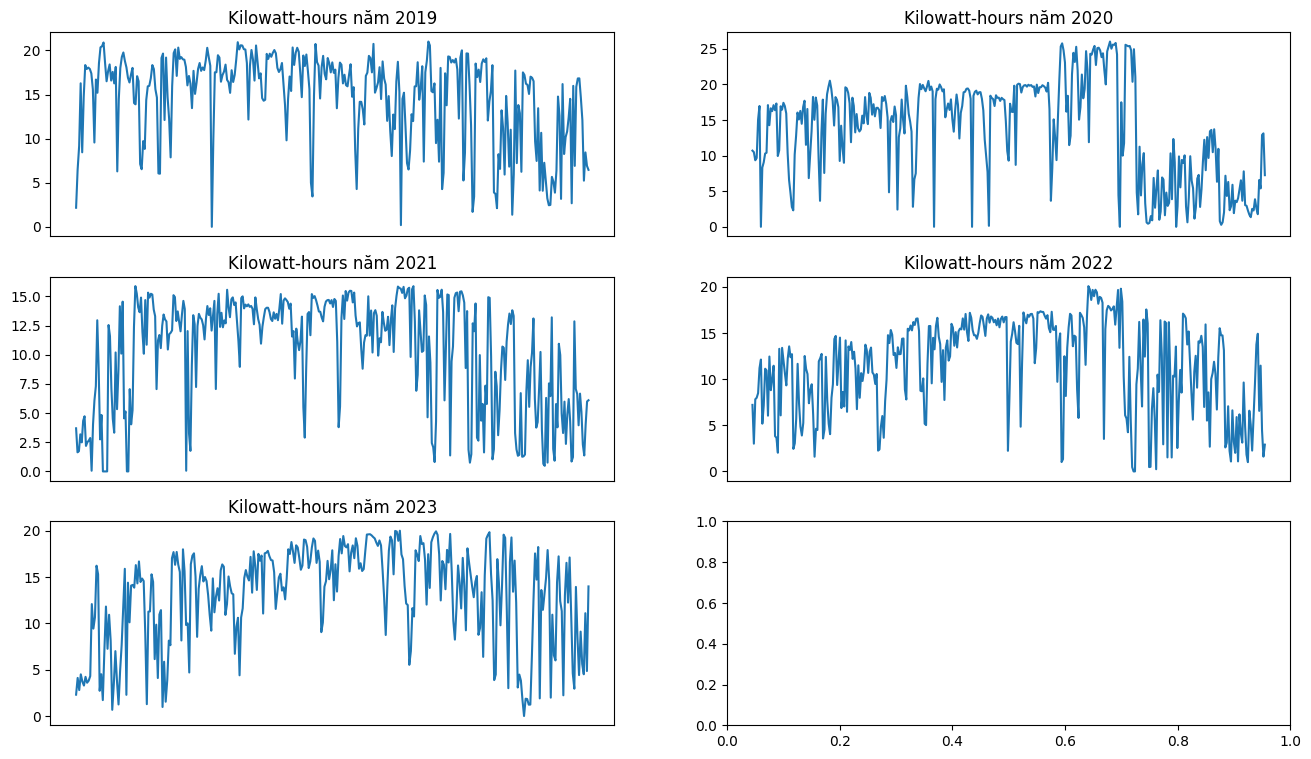

In [ ]:
position = [-1, 337, 703, 1068, 1433, 1761]
fig, axes = plt.subplots(3, 2, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    start = position[i] + 1
    end = position[i+1]
    ax.plot(df['Date'][start:end], df['kilowatt-hours'][start:end], '-')
    ax.set_xticks([])
    ax.set_title(f"Kilowatt-hours năm {2019 + i}")
    if i == 4: break

plt.show()

# 1. Tiền xử lý dữ liệu

In [5]:
df['Weather'] = df['Weather'].map(weather)

df["Date"] = pd.to_datetime(df["Date"])
df["Day_of_Year"] = df["Date"].dt.dayofyear
# df = pd.get_dummies(df, columns=["Weather"]).astype(float)
df

,kilowatt-hours,Date,TempMin,TempMax,Weather,Wind_speed,Humidity,ALLSKY_SFC_SW_DWN,Day_of_Year
0,2.165,2019-01-28,18.69,24.43,0.27,2.81,88.88,1.99,28
1,6.470,2019-01-29,19.56,24.33,0.27,3.48,88.50,2.83,29
2,9.157,2019-01-30,19.38,24.42,0.27,3.29,87.06,5.41,30
3,16.269,2019-01-31,19.06,25.05,0.99,1.98,82.44,5.83,31
4,8.447,2019-02-01,19.03,24.25,0.22,2.64,83.88,5.06,32
...,...,...,...,...,...,...,...,...,...
1757,4.514,2023-11-20,21.48,25.49,0.33,3.85,85.00,4.07,324
1758,11.096,2023-11-21,21.13,25.69,0.27,2.61,82.06,4.53,325
1759,4.860,2023-11-22,22.58,27.11,0.33,2.69,84.19,2.83,326
1760,13.984,2023-11-23,22.44,26.48,0.33,3.73,85.31,4.98,327


In [6]:
df = df.drop("Date", axis=1)

# 2. Tạo dữ liệu

In [7]:
X = []
y = []

n = 14
m = 1

dataframe = df[["kilowatt-hours", "ALLSKY_SFC_SW_DWN", "TempMin", "Weather", "Wind_speed", "Day_of_Year"]].values
for i in range(len(dataframe) - (m + n)):
    X.append(dataframe[i:i+n])
    y.append(dataframe[i+n:i+n+m, 0])
X = np.array(X)
y = np.array(y)


print(X.shape, y.shape)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

(1747, 14, 6) (1747, 1)


# 3. Huấn luyện

In [45]:
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D
from keras.utils import plot_model
from keras.layers import TimeDistributed, Reshape, RepeatVector, ConvLSTM2D


X_val = X_val.reshape(X_val.shape[0], 14, 1,1, 6)
def build_model(X_train, y_train):
    samples, timestep, features = X_train.shape
    output_dim = y_train.shape[1]
    X_train = X_train.reshape(samples, timestep, 1, 1, features)
    # md = Sequential()
    # md.add(Conv2D(64, padding="same", kernel_size=3, activation="relu", input_shape=(timestep, features, 1)))
    # md.add(Conv2D(128, padding="same", kernel_size=3, activation="relu"))
    # md.add(Dropout(0.1))
    # md.add(Flatten())
    # md.add(TimeDistributed(LSTM(128)))
    # md.add(TimeDistributed(Dense(1, activation="relu")))
    # md.add(Dense(128, activation="relu"))
    # md.add(Dense(256, activation="relu"))
    # md.add(Dense(output_dim))
    md = Sequential()
    md.add(ConvLSTM2D(filters=64, padding="same", kernel_size=3, activation='relu', input_shape=(timestep, 1, 1, features)))
    md.add(Flatten())
    md.add(RepeatVector(timestep))
    md.add(LSTM(200, activation='tanh', return_sequences=True))
    md.add(TimeDistributed(Dense(100, activation='relu')))
    md.add(TimeDistributed(Dense(1)))
    md.compile(loss='mse', optimizer='adam')


    stop = EarlyStopping(monitor="val_loss", patience=5)
    md.compile(loss="mse", optimizer="adam", metrics=["mae"])
    his = md.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0, validation_data=(X_val, y_val), callbacks=[stop])
    print(his.history['loss'][-1])
    return md

model = build_model(X_train, y_train)

# plot_model(model, show_shapes=True)


15.57101821899414


In [46]:
X_test = X_test.reshape(X_test.shape[0], 14, 1, 1, 6)

print(model.evaluate(X_test, y_test, verbose=0))

[16.315811157226562, 3.0614161491394043]
